In [4]:
import itertools
import functools
import collections
import random
import re
import glob
import math
import os
import json
import pickle

import pyranges as pr

#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

#import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import scipy
from scipy.special import loggamma
from scipy.special import expit, logit
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import statannot
import plotnine as p9
import sklearn
from sklearn import ensemble
from sklearn import pipeline
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import tensorflow_hub as hub
import tensorflow as tf
# Make sure the GPU is enabled 
#assert tf.config.list_physical_devices('GPU')

from Code.Utilities.seq_utils import one_hot_encode, rev_comp_sequence, rev_comp_one_hot, compute_offset_to_center_landmark
from Code.Utilities.enformer_utils import *

import Code.Utilities.basenji2_utils as basenji2_utils
import Code.Utilities.basenji1_utils as basenji1_utils
import kipoi

transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = 'Data/Genome/genome.fa'
fasta_file_hg19 = 'Data/Genome/genome_hg19.fa'
gtf_file = 'Data/Genome/genes.gtf'


In [5]:
fasta_extractor = FastaStringExtractor(fasta_file)

In [6]:
base_path_data = "Data/Fulco_CRISPRi/"
base_path_results = "Results/Fulco_CRISPRi/"
base_path_results_shift = "Results/Enhancer_shift/"

# Prepare the enhancer shift

In [4]:
gasperini_df = pd.read_csv(base_path_data + "gasperini.tsv",sep="\t")
gasperini_df["liftover_coord"] = pd.read_csv(base_path_data + "hglft_genome_2c397_7c34e0.bed",header=None)
gasperini_df["ziga_key"] = "gasperini2019_" + gasperini_df["target_gene_short"] + "_" + gasperini_df["liftover_coord"].apply(lambda x: x.split(':')[1])
gasperini_df["Absolute Pct Change"] = np.abs((1-gasperini_df["Diff_expression_test_fold_change"])*100)

In [5]:
fulco_df = pd.read_csv(base_path_data + "enhancer_knockdown_effects.tsv",sep="\t")
fulco_df["fulco_key"] = fulco_df["Gene"] + "_" + fulco_df['Element name']

In [6]:
results = pd.read_csv(base_path_results + "avsec_fulltable_fixed-enformer-latest_results.tsv",sep="\t")

In [7]:
results = results.groupby(['ziga_key','fulco_key','gene','enhancer_modification'])[[k for k in results.keys() if ("CAGE" in k) or ("DNASE" in k)]].mean().reset_index()
ziga_df = pd.read_csv(base_path_data + "ziga_additional_columns.tsv",sep="\t")
ziga_df["signed_tss_distance"] = (ziga_df['fix_enhancer_wide_start'] + ziga_df['fix_enhancer_wide_end'])/2 - (ziga_df['main_tss_start'] + ziga_df['main_tss_end'])/2
baseline = results.query('enhancer_modification == "none"').drop(columns=["enhancer_modification"])
ko = results.query('enhancer_modification == "shuffle"').drop(columns=["enhancer_modification"])
merged_df = baseline.merge(ko, on=['ziga_key','fulco_key','gene'], suffixes=("_ref","_alt"))
merged_df[[k for k in merged_df.keys() if ("CAGE" in k) or ("DNASE" in k)]] = np.log2(merged_df[[k for k in merged_df.keys() if ("CAGE" in k) or ("DNASE" in k)]]+1)
merged_df = merged_df.merge(ziga_df, on=["ziga_key",'fulco_key','gene'])
pred_col = "CAGE:chronic myelogenous leukemia cell line:K562 ENCODE, biol__landmark_sum"
merged_df['log2_fc_pred'] = merged_df[pred_col+"_alt"] - merged_df[pred_col+"_ref"]
merged_df['Predicted_Percent'] = np.abs(2**merged_df["log2_fc_pred"]-1)*100


fulco_merged = merged_df.merge(fulco_df[["fulco_key",'Fraction change in gene expr', 'Adjusted p-value', 'Significant',
       'RNA readout method', 'Perturbation method', 'nKO', 'nCtrl', 'semKO',
       'semCtrl', 'Power to detect 25% effects', 'Gene TSS',
       'Normalized HiC Contacts', 'DHS (RPM)', 'H3K27ac (RPM)', 'Activity',
       'ABC Score', 'Reference']], on='fulco_key')
fulco_merged['log2_fc_obs'] = np.log2(1 + fulco_merged['Fraction change in gene expr'])
fulco_merged["Observed_Percent"] = np.abs(fulco_merged['Fraction change in gene expr']*100)


gasperini_merged = merged_df.merge(gasperini_df[['ENSG', 'target_gene_short',
       'Diff_expression_test_raw_pval', 'Diff_expression_test_fold_change',
       'Diff_expression_test_Empirical_pval',
       'Diff_expression_test_Empirical_adjusted_pval',
       'high_confidence_subset', 'chr.candidate_enhancer',
       'start.candidate_enhancer', 'stop.candidate_enhancer', 'liftover_coord',
       'ziga_key']], on='ziga_key')

gasperini_merged['log2_fc_obs'] = np.log2(gasperini_merged['Diff_expression_test_fold_change'])
gasperini_merged["Observed_Percent"] = np.abs(1 - gasperini_merged['Diff_expression_test_fold_change'])*100

In [8]:
keys = ["ziga_key", 
        'chromosome',
        'main_tss_start',
        'main_tss_end',
        'main_tss_bin',
        'fix_enhancer_wide_start',
        'fix_enhancer_wide_end',
        'actual_tss_distance',
        'signed_tss_distance',
        'validated',
        'log2_fc_obs','log2_fc_pred',
        'Observed_Percent', 'Predicted_Percent']

crispr_df = pd.concat([fulco_merged[keys],gasperini_merged[keys]])

In [9]:
len(crispr_df.sort_values(["Predicted_Percent",'Observed_Percent']).query('actual_tss_distance < 5_000 and not validated').query('Observed_Percent > Predicted_Percent'))

8

In [10]:
crispr_df.sort_values(["Predicted_Percent",'Observed_Percent']).query('actual_tss_distance < 5_000 and not validated')

,ziga_key,chromosome,main_tss_start,main_tss_end,main_tss_bin,fix_enhancer_wide_start,fix_enhancer_wide_end,actual_tss_distance,signed_tss_distance,validated,log2_fc_obs,log2_fc_pred,Observed_Percent,Predicted_Percent
115,fulco2019_CALR_12936451-12936951,chr19,12938575,12938703,443,12935701,12937701,1938,-1938.0,False,-0.232202,-0.000309,14.866557,0.021396
113,fulco2019_CALR_12933494-12934071,chr19,12938575,12938703,443,12932782,12934782,4857,-4857.0,False,-0.151562,-0.002299,9.972479,0.159207
1009,fulco2019_RAB7A_128723222-128723762,chr3,128726162,128726290,62,128722492,128724492,2734,-2734.0,False,-0.292776,-0.004297,18.367001,0.297427
114,fulco2019_CALR_12934171-12934671,chr19,12938575,12938703,443,12933421,12935421,4218,-4218.0,False,-0.338803,-0.014634,20.930311,1.009199
25,fulco2019_BAX_48951008-48951608,chr19,48954792,48954920,447,48950308,48952308,3548,-3548.0,False,-0.004489,0.030790,0.310694,2.157134
1139,fulco2019_WDR83OS_12671911-12672491,chr19,12669407,12669535,448,12671201,12673201,2730,2730.0,False,-0.192162,0.035624,12.470723,2.500013
272,fulco2019_DNASE2_12885011-12885511,chr19,12881458,12881586,448,12884261,12886261,3739,3739.0,False,-0.060869,-0.042743,4.131365,2.919233
622,fulco2019_JUNB_12796031-12796931,chr19,12791485,12791613,448,12795481,12797481,4932,4932.0,False,0.090139,-0.047836,6.447250,3.261352
319,fulco2019_FTL_48969788-48970308,chr19,48965308,48965436,448,48969048,48971048,4676,4676.0,False,-0.071956,-0.065769,4.865263,4.456382
473,fulco2019_HDAC6_48798238-48798738,chrX,48801387,48801515,431,48797488,48799488,2963,-2963.0,False,0.060164,-0.071489,4.258442,4.834472


In [11]:
crispr_df.query('actual_tss_distance >= 3000')

,ziga_key,chromosome,main_tss_start,main_tss_end,main_tss_bin,fix_enhancer_wide_start,fix_enhancer_wide_end,actual_tss_distance,signed_tss_distance,validated,log2_fc_obs,log2_fc_pred,Observed_Percent,Predicted_Percent
0,fulco2019_BAX_48830068-48830588,chr19,48954792,48954920,447,48829328,48831328,124528,-124528.0,False,-0.014240,-2.334924e-05,0.982170,0.001618
1,fulco2019_BAX_48835628-48836148,chr19,48954792,48954920,447,48834888,48836888,118968,-118968.0,False,0.010956,9.463489e-08,0.762330,0.000007
2,fulco2019_BAX_48842428-48843148,chr19,48954792,48954920,447,48841788,48843788,112068,-112068.0,False,-0.023633,4.305041e-06,1.624791,0.000298
3,fulco2019_BAX_48844388-48844908,chr19,48954792,48954920,447,48843648,48845648,110208,-110208.0,False,0.000628,-3.044953e-06,0.043557,0.000211
4,fulco2019_BAX_48853988-48854508,chr19,48954792,48954920,447,48853248,48855248,100608,-100608.0,False,0.060485,7.378508e-05,4.281626,0.005115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,gasperini2019_ZMYND8_47360522-47361177,chr20,47356715,47356843,476,47359849,47361849,4070,4070.0,True,-0.285046,-4.595382e-01,17.928468,27.278098
466,gasperini2019_ZNF273_64849376-64849959,chr7,64903246,64903374,448,64848667,64850667,53643,-53643.0,True,-0.197929,1.689183e-02,12.819897,1.177734
467,gasperini2019_ZNF431_21128818-21129149,chr19,21141914,21142042,447,21127983,21129983,12995,-12995.0,True,-0.613139,1.786761e-02,34.622735,1.246189
468,gasperini2019_ZNF672_248884984-248885196,chr1,248838249,248838377,445,248884090,248886090,46777,46777.0,True,-0.216916,1.708117e-02,13.959744,1.191013


## Validated enhancers

In [12]:
valid_enhancer = crispr_df.query('validated and actual_tss_distance >= 3000').sort_values('Observed_Percent')

Select enhancers which are validated but at higher distances:

- 20 distances on each side
- 10 replacements (use the same 10 each time, for comparability) at each distance. Can use weak enhancers!
- 6 augmentations

--> can check around 500 enhancers easily

For each enhancer:
- center sequence on promoter
- make 2x20 rows, each with an enhancer location
- always remember original enhancer location
- also test "N"x2000

Procedure:
- get the sequence from the genome, with enough padding on the correct side to support enhancer cut
- cut out the original enhancer
- place the enhancer according to the indicated position
- ensure tss is now the exact center (use assert)
- ensure that the enhancer is where it is supposed to be (use assert)
- and thats a wrap

In [16]:
505*20*2*(10+1+1)*6 + 505*6

1457430

In [49]:
dists = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,
          12_000, 17_000, 22_000, 27_000, 37_000, 47_000, 
          57_000, 67_000, 77_000, 87_000, 93_000]) + 3000

In [4]:
dists

array([ 3000,  4000,  5000,  6000,  7000,  8000,  9000, 10000, 11000,
       15000, 20000, 25000, 30000, 40000, 50000, 60000, 70000, 80000,
       90000, 96000])

In [50]:
new_rows = []
for _,row in valid_enhancer.iterrows():
    ziga_key = row["ziga_key"]
    chrom = row["chromosome"]
    tss_pos = (row['main_tss_start'] + row['main_tss_end'])//2
    enh_actual_start = row['fix_enhancer_wide_start']
    enh_actual_end = row['fix_enhancer_wide_end']
    actual_distance = enh_actual_start + 1000 - tss_pos
    enh_is_3prime = actual_distance > 0
    for direction in [-1,1]:
        new_enh_is_3prime = direction > 0
        for dist in dists:
            # compute the sequence and the cut positions
            left_offset = 2000*(not enh_is_3prime) - 2000*(not new_enh_is_3prime)
            right_offset = 2000*(enh_is_3prime) - 2000*(new_enh_is_3prime)
            sequence_start = tss_pos - (SEQUENCE_LENGTH//2 + left_offset)
            sequence_end = tss_pos + (SEQUENCE_LENGTH//2 + right_offset)
            enh_insert_pos = SEQUENCE_LENGTH//2 + direction*(dist)
            new_rows.append({
                "ziga_key":ziga_key,
                "enhancer_id":"{}:{}-{}".format(chrom,enh_actual_start,enh_actual_end),
                "chrom":chrom,
                "tss_genome_pos":tss_pos,
                "enh_genome_start":enh_actual_start,
                "enh_genome_end":enh_actual_end,
                "actual_distance":actual_distance,
                "enh_is_3prime":enh_is_3prime,
                "sequence_start":sequence_start,
                "sequence_end":sequence_end,
                "tss_seq_pos":SEQUENCE_LENGTH//2,
                "enh_seq_start":enh_actual_start - sequence_start,
                "enh_seq_end":enh_actual_end - sequence_start,
                "enh_insert_pos":enh_insert_pos,
                "signed_distance":direction*dist,
                "absolute_distance":dist,
                "Observed_Percent": row['Observed_Percent'],
                "Predicted_Percent": row['Predicted_Percent']
            })

In [51]:
enh_shifts = pd.DataFrame(new_rows)

In [27]:
enh_shifts.to_csv(os.path.join(base_path_data, "enhancer_shifts_design.tsv"),
                         sep="\t")

## All enhancers tested

In [52]:
valid_enhancers_tested = set(enh_shifts['ziga_key'])

In [71]:
(1155*2*6*(10+1+1)*6) + (6122*2*1*(10+1+1)*6) + 7277*6

1923150

In [72]:
1155*2*6 + 6122*2*1

26104

In [87]:
merged_df.query('validated')['actual_tss_distance'].describe()

count       636.000000
mean      31058.520440
std       33322.335547
min           9.000000
25%        5137.000000
50%       18259.500000
75%       48592.750000
max      145457.000000
Name: actual_tss_distance, dtype: float64

In [88]:
new_rows = []
for _,row in merged_df.query('actual_tss_distance >= 3000 and ziga_key not in @valid_enhancers_tested').iterrows():
    ziga_key = row["ziga_key"]
    chrom = row["chromosome"]
    tss_pos = (row['main_tss_start'] + row['main_tss_end'])//2
    enh_actual_start = row['fix_enhancer_wide_start']
    enh_actual_end = row['fix_enhancer_wide_end']
    actual_distance = enh_actual_start + 1000 - tss_pos
    enh_is_3prime = actual_distance > 0
    for direction in [-1,1]:
        new_enh_is_3prime = direction > 0
        if not row['ziga_key'].startswith('fulco'):
            distances = np.array([20_000])
        else:
            distances = np.array([3000, 5000, 10_000, 20_000, 50_000, 90_000])
        for dist in distances:
            # compute the sequence and the cut positions
            left_offset = 2000*(not enh_is_3prime) - 2000*(not new_enh_is_3prime)
            right_offset = 2000*(enh_is_3prime) - 2000*(new_enh_is_3prime)
            sequence_start = tss_pos - (SEQUENCE_LENGTH//2 + left_offset)
            sequence_end = tss_pos + (SEQUENCE_LENGTH//2 + right_offset)
            enh_insert_pos = SEQUENCE_LENGTH//2 + direction*(dist)
            new_rows.append({
                "ziga_key":ziga_key,
                "enhancer_id":"{}:{}-{}".format(chrom,enh_actual_start,enh_actual_end),
                "chrom":chrom,
                "tss_genome_pos":tss_pos,
                "enh_genome_start":enh_actual_start,
                "enh_genome_end":enh_actual_end,
                "actual_distance":actual_distance,
                "enh_is_3prime":enh_is_3prime,
                "sequence_start":sequence_start,
                "sequence_end":sequence_end,
                "tss_seq_pos":SEQUENCE_LENGTH//2,
                "enh_seq_start":enh_actual_start - sequence_start,
                "enh_seq_end":enh_actual_end - sequence_start,
                "enh_insert_pos":enh_insert_pos,
                "signed_distance":direction*dist,
                "absolute_distance":dist,
                "Predicted_Percent": row['Predicted_Percent']
            })

In [89]:
all_shifts = pd.DataFrame(new_rows)

In [91]:
all_shifts.to_csv(os.path.join(base_path_data, "all_enhancer_shifts_design.tsv"),
                         sep="\t")

In [90]:
len(all_shifts)

26104

In [21]:
def build_sequence(key, chrom, seq_start, seq_end, 
                   enh_start, enh_end, tss_pos,
                   enh_seq, prom_seq, offset, strand,
                   insert = None, insert_pos = -1):
    base_interval = kipoiseq.Interval(chrom, 
                                      seq_start, 
                                      seq_end)
    base_seq = fasta_extractor.extract(base_interval)
    #print(base_interval)
    #print(base_seq)
    # cut out the actual enhancer
    assert enh_seq == base_seq[enh_start:enh_end], "{}\n{}".format(enh_seq,  base_seq[enh_start:enh_end])
    base_seq = base_seq[:enh_start] + base_seq[enh_end:]
    if insert and insert_pos >= 0:
        # insert at the new position
        base_seq = base_seq[:insert_pos] + insert + base_seq[insert_pos:]
    # check that the tss is indeed at the center
    assert(len([x for x in re.finditer(prom_seq,base_seq)]) > 0), "{}:{}-{}".format(chrom, seq_start, seq_end)
    assert prom_seq == base_seq[tss_pos-500:tss_pos+500], "{}\n{}\n{}\n{}".format(key,
                                                                                  prom_seq,  
                                                                                  base_seq[tss_pos-500:tss_pos+500],
                                                                                  [x for x in re.finditer(prom_seq,base_seq)])
    # perform the shift and the rc 
    base_seq = "N"*max(0,offset) + base_seq[max(0,offset):len(base_seq) + min(0,offset)] + "N"*np.abs(min(0,offset))
    assert len(base_seq) == SEQUENCE_LENGTH, "{} vs. {}".format(len(base_seq), SEQUENCE_LENGTH)
    if strand == "rc":
        base_seq = rev_comp_sequence(base_seq)
    return base_seq

def shuffle_string(string):
    string_as_list = list(string)
    np.random.shuffle(string_as_list)
    return "".join(string_as_list)

In [31]:
def enh_shift_sample_gen_factory(fasta_extractor, num_shuffles=10):
    for _, enh in enhancers.iterrows():
        key = enh["ziga_key"]
        print(key)
        chrom = enh["chrom"]
        enh_is_3prime = enh["enh_is_3prime"]
        enh_interval = kipoiseq.Interval(chrom, 
                                          enh['enh_genome_start'], 
                                          enh['enh_genome_end'])
        enh_seq = fasta_extractor.extract(enh_interval)
        prom_interval = kipoiseq.Interval(chrom, 
                                         enh['tss_genome_pos'] - 500, 
                                         enh['tss_genome_pos'] + 500)
        prom_seq = fasta_extractor.extract(prom_interval)
        # create the possible inserts
        insert_dict = {enh_seq:"enhancer",
                       "N"*2000:"neutral"} # always test these two
        for i in range(num_shuffles):
            insert_dict[shuffle_string(enh_seq)] = "shuffle"
        # predict once without the enhancer
        for offset in [-43, 0, 43]:
            for strand in ["fw", "rv"]:
                seq_start = enh['tss_genome_pos'] - (SEQUENCE_LENGTH//2 + 2000*(not enh_is_3prime))
                seq_end = enh['tss_genome_pos'] + (SEQUENCE_LENGTH//2 + 2000*(enh_is_3prime))
                seq = build_sequence(key=key, chrom=chrom, 
                                     seq_start=seq_start, 
                                     seq_end=seq_end, 
                                     enh_start=enh['enh_genome_start']-seq_start, 
                                     enh_end=enh['enh_genome_end']-seq_start, 
                                     tss_pos=SEQUENCE_LENGTH//2,
                                     enh_seq=enh_seq, 
                                     prom_seq=prom_seq, 
                                     offset=offset, strand=strand)
                yield seq, {"ziga_key": key,
                            "enhancer_id":enh["enhancer_id"],
                            "offset": offset,
                            "orient": strand,
                            "insert_type": "None",
                            "distance": -1,
                            "minbin": 447,
                            "maxbin": 449,
                            "landmarkbin": 448}
        # predict for the inserts
        for _, row in enh_shifts.query('ziga_key == @key').iterrows():
            for insert in insert_dict:
                for offset in [-43, 0, 43]:
                    for strand in ["fw", "rv"]:
                        seq = build_sequence(key=key, chrom=chrom, 
                                             seq_start=row['sequence_start'], 
                                             seq_end=row['sequence_end'], 
                                             enh_start=row['enh_seq_start'], 
                                             enh_end=row['enh_seq_end'], 
                                             tss_pos=row['tss_seq_pos'],
                                             enh_seq=enh_seq, 
                                             prom_seq=prom_seq, 
                                             offset=offset, strand=strand,
                                             insert=insert, 
                                             insert_pos=row['enh_insert_pos'])
                        yield seq, {"ziga_key": key,
                                    "enhancer_id":enh["enhancer_id"],
                                    "offset": offset,
                                    "orient": strand,
                                    "insert_type": insert_dict[insert],
                                    "distance": row['signed_distance'],
                                    "minbin": 447,
                                    "maxbin": 449,
                                    "landmarkbin": 448}

In [40]:
(SEQUENCE_LENGTH//2 - PADDING)/128

448.0

In [41]:
SEQUENCE_LENGTH/2

196608.0

In [ ]:
np.random.seed(42)
x = [x[1] for x in enh_shift_sample_gen_factory(fasta_extractor)]
assert len(x) == 505*20*2*(10+1+1)*6 + 505*6

# Analyze the distance dependence for validated enhancers

"This is a reasonable explanation, but I wondered if it could be tested using in silico sequences? Could validated distal enhancers be varied (in silico) in their positions w.r.t. the TSS to demonstrate that distance is a strong determinant of predicted effect size? In other words, how far do you need to "move" an enhancer before Enformer predicts the correct effect size? And does Enformer then over-predict effect size if you move the enhancer too close to the TSS?"

In [7]:
enh_shifts = pd.read_csv(base_path_data + "enhancer_shifts_design.tsv", sep="\t").drop(columns=['Unnamed: 0'])

enhancers = enh_shifts[['ziga_key', 'enhancer_id', 'chrom',  'actual_distance', 'Observed_Percent', 'Predicted_Percent']].drop_duplicates()
enhancers['actual_abs_distance'] = np.abs(enhancers['actual_distance'])

In [8]:
key_cols = ['ziga_key','enhancer_id','distance','insert_type']
pred_col = 'CAGE:chronic myelogenous leukemia cell line:K562 ENCODE, biol__landmark_sum'

In [ ]:
cage_cols = [x for x in pd.read_csv(base_path_results_shift + 
                                    "enhancer_shift-enformer-latest_results.tsv",
                                    sep="\t",
                                    nrows=2).keys()
            if "CAGE" in x and x.endswith("landmark_sum")]


results = pd.read_csv(base_path_results_shift + "enhancer_shift-enformer-latest_results.tsv",sep="\t",
                     usecols=key_cols+[pred_col])

In [ ]:
results = results.groupby(key_cols)[[pred_col]].mean().reset_index()

In [ ]:
results.to_csv(base_path_results_shift + "enhancer_shift-enformer-k562_aggregated.tsv",sep="\t",index=None)

In [10]:
results = pd.read_csv(base_path_results_shift + "enhancer_shift-enformer-k562_aggregated.tsv",sep="\t")

In [11]:
results[pred_col] = np.log2(results[pred_col] + 1)

In [12]:
no_enh = results.query('insert_type == "None"')
neutral_enh = results.query('insert_type == "neutral"')
shuffled_enh = results.query('insert_type == "shuffle"')
with_enh = results.query('insert_type == "enhancer"')

In [13]:
enh_effect = with_enh.drop(columns=["insert_type"]).merge(shuffled_enh.drop(columns=["insert_type"]), on=key_cols[:3],suffixes=("","_shuffled"))
enh_effect["log2_fc"] =  enh_effect[pred_col+"_shuffled"] - enh_effect[pred_col]
enh_effect["log2_fc_abs"] =  np.abs(enh_effect["log2_fc"])
enh_effect['Predicted_Percent'] = np.abs(2**enh_effect["log2_fc"]-1)*100
enh_effect["abs_dist"] = np.abs(enh_effect["distance"])

## Plot distance effect

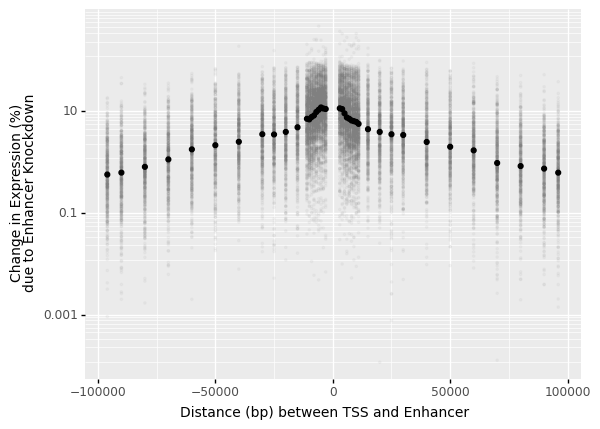

<ggplot: (1445256977390)>

In [15]:
plot_df = enh_effect.copy()
plot_df = plot_df.groupby("distance").median().reset_index()

p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="distance",y="Predicted_Percent"))
 + p9.geom_point(data=enh_effect,alpha=0.05,size=0.5,color="grey")
+ p9.geom_point()
 + p9.scale_y_log10()
 + p9.labs(x="Distance (bp) between TSS and Enhancer",y="Change in Expression (%)\ndue to Enhancer Knockdown", color="", fill="")
 + p9.theme(legend_key_size=9,legend_text=p9.element_text(size=9),
            legend_position=(0.21,0.2),legend_background=p9.element_blank(),
            #axis_text_x=p9.element_text(rotation=30, hjust=1),
            axis_title=p9.element_text(size=10), subplots_adjust={'wspace': 0.2}
           )
) 
p

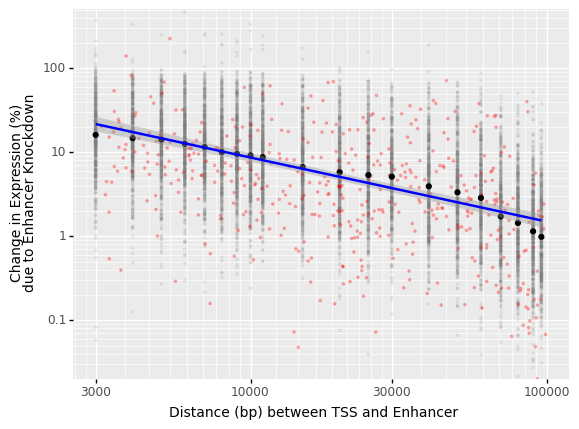

<ggplot: (1445251572730)>

In [31]:
plot_df = enh_effect.copy()
# aggregate 5' and 3'
#plot_df["abs_dist"] = np.abs(plot_df["distance"])
plot_df = plot_df.groupby(["ziga_key","abs_dist"]).max().reset_index()[["ziga_key","abs_dist","Predicted_Percent"]]
plot_df['shifted'] = True
# get medians
plot_df_aggreg = plot_df.groupby("abs_dist").median().reset_index()
# add original positions
unshifted = (enhancers
             .rename(columns={'actual_abs_distance':'abs_dist'})
             [["ziga_key","abs_dist","Predicted_Percent"]]
             .query('abs_dist < 100_000')
            )
unshifted["shifted"] = False


p = (p9.ggplot(data=plot_df_aggreg, mapping=p9.aes(x="abs_dist",y="Predicted_Percent"))
 + p9.geom_point(data=plot_df,alpha=0.1,size=0.5,color="grey", raster=True)
 + p9.geom_point(data=unshifted,alpha=0.25,size=0.5,color="red", raster=True)
 + p9.geom_point()
 + p9.scale_x_log10()
 + p9.scale_y_log10()
 + p9.coord_cartesian(ylim=(-1.5,2.5))
 + p9.geom_smooth(method="lm", color="blue")
 + p9.labs(x="Distance (bp) between TSS and Enhancer",y="Change in Expression (%)\ndue to Enhancer Knockdown", color="", fill="")
 + p9.theme(legend_key_size=9,legend_text=p9.element_text(size=9),
            legend_position=(0.21,0.2),legend_background=p9.element_blank(),
            #axis_text_x=p9.element_text(rotation=30, hjust=1),
            axis_title=p9.element_text(size=10), subplots_adjust={'wspace': 0.2}
           )
) 
p

In [32]:
p.save("Graphics/" + "xsup_shift_general" + ".png", width=6.4, height=4.8, dpi=300)

/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/modules/i12g/anaconda/envs/karollus-tfhub/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: Graphics/xsup_shift_general.png


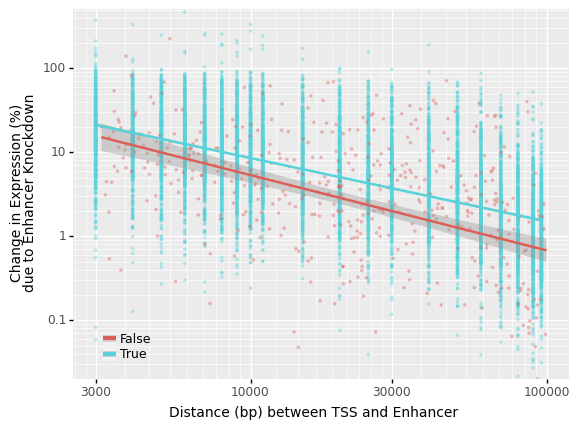

<ggplot: (1445251914066)>

In [17]:
plot_df_all = pd.concat([plot_df, unshifted])

(p9.ggplot(data=plot_df_all, mapping=p9.aes(x="abs_dist",y="Predicted_Percent", color="shifted"))
 + p9.geom_point(alpha=0.3,size=0.5, raster=True)
 + p9.scale_x_log10()
 + p9.scale_y_log10()
 + p9.coord_cartesian(ylim=(-1.5,2.5))
 + p9.geom_smooth(method="lm")
 + p9.labs(x="Distance (bp) between TSS and Enhancer",y="Change in Expression (%)\ndue to Enhancer Knockdown", color="", fill="")
 + p9.theme(legend_key_size=9,legend_text=p9.element_text(size=9),
            legend_position=(0.21,0.2),
            legend_background=p9.element_blank(),
            #axis_text_x=p9.element_text(rotation=30, hjust=1),
            axis_title=p9.element_text(size=10), subplots_adjust={'wspace': 0.2}
           )
) 

1.2327785147297488


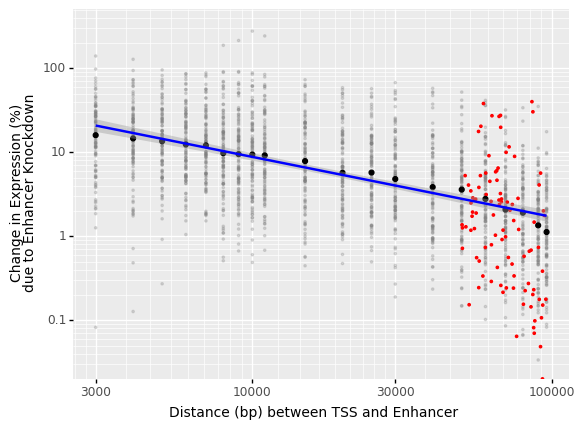

<ggplot: (1460061705807)>

In [23]:
query = 'actual_abs_distance > 50_000 and actual_abs_distance < 96_000 & Observed_Percent > 10'
far_enhancers = set(enhancers.query(query)['ziga_key'])
print(np.median(enhancers.query(query)['Predicted_Percent']))
plot_df_far = plot_df.query('ziga_key in @far_enhancers')
unshifted_far = unshifted.query('ziga_key in @far_enhancers')
plot_df_aggreg_far = plot_df_far.query('shifted').groupby("abs_dist").median().reset_index()

(p9.ggplot(data=plot_df_aggreg_far, mapping=p9.aes(x="abs_dist",y="Predicted_Percent"))
 + p9.geom_point(data=plot_df_far,alpha=0.25,size=0.5,color="grey", raster=True)
 + p9.geom_point(data=unshifted_far,alpha=1,size=0.5,color="red", raster=True)
 + p9.geom_point()
 + p9.scale_x_log10()
 + p9.scale_y_log10()
 + p9.coord_cartesian(ylim=(-1.5,2.5))
 + p9.geom_smooth(method="lm", color="blue")
 + p9.labs(x="Distance (bp) between TSS and Enhancer",y="Change in Expression (%)\ndue to Enhancer Knockdown", color="", fill="")
 + p9.theme(legend_key_size=9,legend_text=p9.element_text(size=9),
            legend_position=(0.21,0.2),legend_background=p9.element_blank(),
            #axis_text_x=p9.element_text(rotation=30, hjust=1),
            axis_title=p9.element_text(size=10), subplots_adjust={'wspace': 0.2}
           )
) 

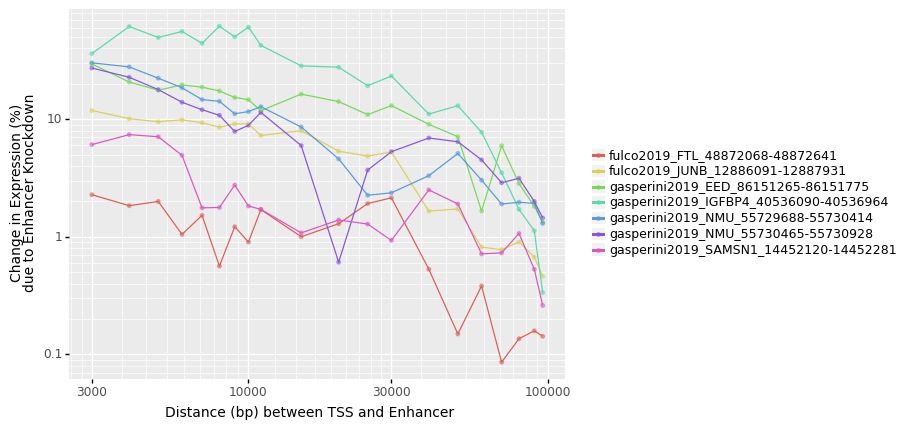

<ggplot: (1460061645322)>

In [24]:
far_enhancers = set(enhancers.query('actual_abs_distance > 93_000 and actual_abs_distance < 96_000')['ziga_key'])
plot_df_line = plot_df.query('ziga_key in @far_enhancers')

(p9.ggplot(data=plot_df_line, mapping=p9.aes(x="abs_dist",y="Predicted_Percent", group="ziga_key", color="ziga_key"))
 + p9.geom_point(alpha=0.5,size=1, raster=True)
 + p9.geom_line()
 #+ p9.geom_point()
 + p9.scale_x_log10()
 + p9.scale_y_log10()
 #+ p9.geom_smooth(method="lm", color="blue")
 + p9.labs(x="Distance (bp) between TSS and Enhancer",y="Change in Expression (%)\ndue to Enhancer Knockdown", color="", fill="")
 + p9.theme(legend_key_size=9,legend_text=p9.element_text(size=9),
            #legend_position=(0.21,0.2),
            legend_background=p9.element_blank(),
            #axis_text_x=p9.element_text(rotation=30, hjust=1),
            axis_title=p9.element_text(size=10), subplots_adjust={'wspace': 0.2}
           )
) 

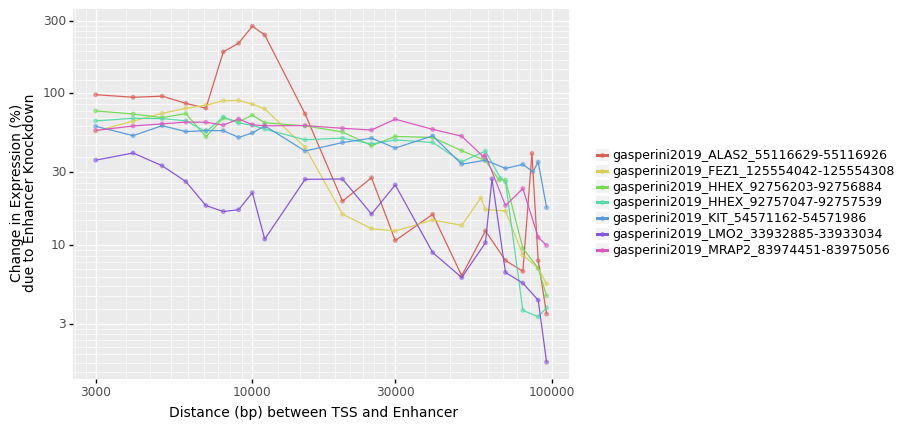

<ggplot: (1445251751653)>

In [18]:
far_enhancers = set(enhancers.query('actual_abs_distance > 50_000 and Predicted_Percent > 20')['ziga_key'])
plot_df_line = plot_df_all.query('ziga_key in @far_enhancers')


(p9.ggplot(data=plot_df_line, mapping=p9.aes(x="abs_dist",y="Predicted_Percent", group="ziga_key", color="ziga_key"))
 + p9.geom_point(alpha=0.5,size=1, raster=True)
 + p9.geom_line()
 #+ p9.geom_point()
 + p9.scale_x_log10()
 + p9.scale_y_log10()
 #+ p9.geom_smooth(method="lm", color="blue")
 + p9.labs(x="Distance (bp) between TSS and Enhancer",y="Change in Expression (%)\ndue to Enhancer Knockdown", color="", fill="")
 + p9.theme(legend_key_size=9,legend_text=p9.element_text(size=9),
            #legend_position=(0.21,0.2),
            legend_background=p9.element_blank(),
            #axis_text_x=p9.element_text(rotation=30, hjust=1),
            axis_title=p9.element_text(size=10), subplots_adjust={'wspace': 0.2}
           )
) 

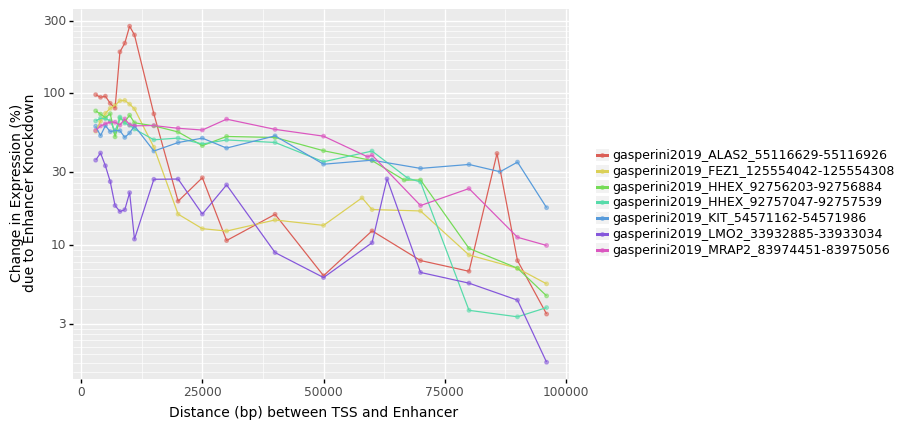

<ggplot: (1445251658734)>

In [30]:
(p9.ggplot(data=plot_df_line, mapping=p9.aes(x="abs_dist",y="Predicted_Percent", group="ziga_key", color="ziga_key"))
 + p9.geom_point(alpha=0.5,size=1, raster=True)
 + p9.geom_line()
 #+ p9.geom_point()
 #+ p9.scale_x_log10()
 + p9.scale_y_log10()
 #+ p9.geom_smooth(method="lm", color="blue")
 + p9.labs(x="Distance (bp) between TSS and Enhancer",y="Change in Expression (%)\ndue to Enhancer Knockdown", color="", fill="")
 + p9.theme(legend_key_size=9,legend_text=p9.element_text(size=9),
            #legend_position=(0.21,0.2),
            legend_background=p9.element_blank(),
            #axis_text_x=p9.element_text(rotation=30, hjust=1),
            axis_title=p9.element_text(size=10), subplots_adjust={'wspace': 0.2}
           )
) 

In [22]:
far_enhancers

{'gasperini2019_ALAS2_55116629-55116926',
 'gasperini2019_FEZ1_125554042-125554308',
 'gasperini2019_HHEX_92756203-92756884',
 'gasperini2019_HHEX_92757047-92757539',
 'gasperini2019_KIT_54571162-54571986',
 'gasperini2019_LMO2_33932885-33933034',
 'gasperini2019_MRAP2_83974451-83975056'}

In [29]:
plot_df_line.sort_values(['ziga_key','abs_dist']).query('ziga_key == "gasperini2019_MRAP2_83974451-83975056"')

,ziga_key,abs_dist,Predicted_Percent,shifted
6560,gasperini2019_MRAP2_83974451-83975056,3000,56.734097,True
6561,gasperini2019_MRAP2_83974451-83975056,4000,60.718732,True
6562,gasperini2019_MRAP2_83974451-83975056,5000,62.721191,True
6563,gasperini2019_MRAP2_83974451-83975056,6000,64.438528,True
6564,gasperini2019_MRAP2_83974451-83975056,7000,64.240551,True
6565,gasperini2019_MRAP2_83974451-83975056,8000,61.525196,True
6566,gasperini2019_MRAP2_83974451-83975056,9000,67.571291,True
6567,gasperini2019_MRAP2_83974451-83975056,10000,61.854953,True
6568,gasperini2019_MRAP2_83974451-83975056,11000,60.830432,True
6569,gasperini2019_MRAP2_83974451-83975056,15000,61.064374,True


## Can we rank validated enhancers better if we equalize the distance?

In [26]:
enh_obs = enhancers[['ziga_key','Predicted_Percent','Observed_Percent','actual_abs_distance']].rename(columns={'actual_abs_distance':"abs_dist"})
dist_effect = enh_effect.groupby(["ziga_key","abs_dist"]).max().reset_index()[["ziga_key","abs_dist","Predicted_Percent"]]
pred_obs = dist_effect.merge(enh_obs, on=["ziga_key"], suffixes=("_shifted","_unshifted"))

In [27]:
scipy.stats.spearmanr(enh_obs['Predicted_Percent'], 
                      enh_obs['Observed_Percent'])

SpearmanrResult(correlation=0.3113764161218804, pvalue=8.144452481687169e-13)

In [129]:

data = pred_obs.query('abs_dist_shifted == 20_000')
bootstraps = []
for i in range(10_000):
    smpl = data.sample(frac=1,replace=True)
    unshifted = scipy.stats.pearsonr(np.log(smpl['Predicted_Percent_unshifted']), 
                                      np.log(smpl['Observed_Percent']))[0]
    shifted = scipy.stats.pearsonr(np.log(smpl['Predicted_Percent_shifted']), 
                                      np.log(smpl['Observed_Percent']))[0]
    bootstraps.append(shifted - unshifted)
        


In [130]:
bootstraps = pd.Series(bootstraps)
bootstraps.quantile([0.025])

0.025    0.110344
dtype: float64

In [132]:
np.sum(bootstraps > 0)/10_000

1.0

In [138]:
corr_plot = (pred_obs
             .query("abs_dist_shifted == 20_000")
             [['ziga_key', 'Observed_Percent', 'Predicted_Percent_shifted', 'Predicted_Percent_unshifted']]
             .melt(id_vars=['ziga_key', 'Observed_Percent'])
            )
corr_plot['annot'] = corr_plot['variable'].apply(lambda x: "Shifted" if x.endswith("_shifted") else "Native")

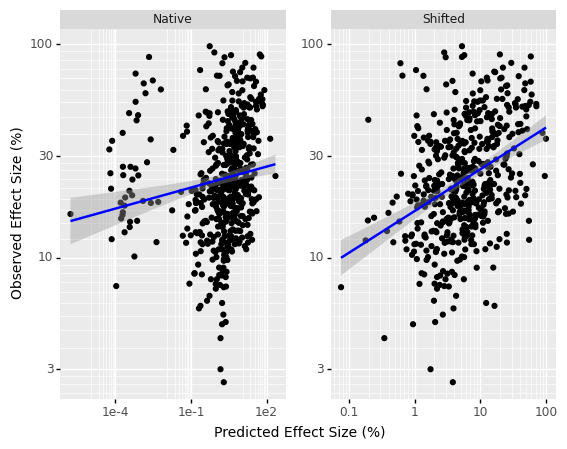

<ggplot: (1460053661148)>

In [142]:
(p9.ggplot(data=corr_plot, mapping=p9.aes(x="value",y="Observed_Percent"))
 + p9.geom_point(raster=True)
 + p9.scale_x_log10()
 + p9.scale_y_log10()
 #+ p9.coord_cartesian(ylim=(-1.5,2.5))
 + p9.geom_smooth(method="lm", color="blue")
 #+ p9.geom_abline()
 + p9.labs(x="Predicted Effect Size (%)",y="Observed Effect Size (%)", color="", fill="")
 + p9.theme(legend_key_size=9,legend_text=p9.element_text(size=9),
            legend_position=(0.21,0.2),legend_background=p9.element_blank(),
            #axis_text_x=p9.element_text(rotation=30, hjust=1),
            axis_title=p9.element_text(size=10), subplots_adjust={'wspace': 0.2}
           )
 + p9.facet_wrap('~ annot', scales="free")
) 

## Can we get higher effect sizes than were measured?

In [33]:
# can we exceed measured effect by shifting
print(len(pred_obs['ziga_key'].drop_duplicates()))
print(len(pred_obs.query('Predicted_Percent_unshifted > Observed_Percent')['ziga_key'].drop_duplicates()))
print(len(pred_obs.query('abs_dist_shifted < abs_dist_unshifted and Predicted_Percent_shifted > Observed_Percent')['ziga_key'].drop_duplicates()))

505
34
221


In [34]:
# can we exceed measured effect by shifting distal ones
print(len(pred_obs.query('abs_dist_unshifted > 80_000')['ziga_key'].drop_duplicates()))
print(len(pred_obs.query('abs_dist_unshifted > 80_000 and Predicted_Percent_unshifted > Observed_Percent')['ziga_key'].drop_duplicates()))
print(len(pred_obs.query('abs_dist_unshifted > 80_000 and abs_dist_shifted < abs_dist_unshifted and Predicted_Percent_shifted > Observed_Percent')['ziga_key'].drop_duplicates()))

78
1
42


In [35]:
# can we exceed 10% by shifting
print(len(pred_obs['ziga_key'].drop_duplicates()))
print(len(pred_obs.query('Predicted_Percent_unshifted > 10')['ziga_key'].drop_duplicates()))
print(len(pred_obs.query('abs_dist_shifted < abs_dist_unshifted and Predicted_Percent_shifted > 10')['ziga_key'].drop_duplicates()))

505
111
401


In [36]:
# can we exceed 10% by shifting distal ones
print(len(pred_obs.query('abs_dist_unshifted > 80_000')['ziga_key'].drop_duplicates()))
print(len(pred_obs.query('abs_dist_unshifted > 80_000 and Predicted_Percent_unshifted > 10')['ziga_key'].drop_duplicates()))
print(len(pred_obs.query('abs_dist_unshifted > 80_000 and abs_dist_shifted < abs_dist_unshifted and Predicted_Percent_shifted > 10')['ziga_key'].drop_duplicates()))

78
2
61


In [37]:
max_effects = pred_obs.groupby('ziga_key')[['Predicted_Percent_shifted', 'Predicted_Percent_unshifted', 'Observed_Percent', 'abs_dist_unshifted']].max().reset_index()

In [38]:
(max_effects['Predicted_Percent_shifted'] - max_effects['Observed_Percent']).describe()

count    505.000000
mean       2.570192
std       36.505356
min      -85.649380
25%      -10.832552
50%       -1.401220
75%       10.858415
max      442.469522
dtype: float64

# Analyze all enhancers, when evaluated at a fixed distance

In [39]:
key_cols = ['ziga_key','enhancer_id','distance','insert_type']
pred_col = 'CAGE:chronic myelogenous leukemia cell line:K562 ENCODE, biol__landmark_sum'

In [40]:
cage_cols = [x for x in pd.read_csv(base_path_results_shift + 
                                    "enhancer_shift-enformer-latest_results.tsv",
                                    sep="\t",
                                    nrows=2).keys()
            if "CAGE" in x and x.endswith("landmark_sum")]


results_all = pd.read_csv(base_path_results_shift + "enhancer_shift_fulltable-enformer-latest_results.tsv",sep="\t",
                     usecols=key_cols+[pred_col])

In [41]:
results_all = results_all.groupby(key_cols)[[pred_col]].mean().reset_index()

In [42]:
#results_all.to_csv(base_path_results_shift + "enhancer_shift_full-enformer-k562_aggregated.tsv",sep="\t",index=None)

In [43]:
#results_all = pd.read_csv(base_path_results_shift + "enhancer_shift_full-enformer-k562_aggregated.tsv",sep="\t")

In [44]:
results_all[pred_col] = np.log2(results_all[pred_col] + 1)

In [45]:
no_enh_all = results_all.query('insert_type == "None"')
neutral_enh_all = results_all.query('insert_type == "neutral"')
shuffled_enh_all = results_all.query('insert_type == "shuffle"')
with_enh_all = results_all.query('insert_type == "enhancer"')

In [46]:
enh_effect_all = with_enh_all.drop(columns=["insert_type"]).merge(shuffled_enh_all.drop(columns=["insert_type"]), on=key_cols[:3],suffixes=("","_shuffled"))
enh_effect_all["log2_fc"] =  enh_effect_all[pred_col+"_shuffled"] - enh_effect_all[pred_col]
enh_effect_all["log2_fc_abs"] =  np.abs(enh_effect_all["log2_fc"])
enh_effect_all['Predicted_Percent'] = np.abs(2**enh_effect_all["log2_fc"]-1)*100
enh_effect_all["abs_dist"] = np.abs(enh_effect_all["distance"])

In [47]:
dist_effect_all = (enh_effect_all
                   .query('abs_dist == 20_000')
                   .groupby(["ziga_key","abs_dist"])
                   .max()
                   .reset_index()
                   [["ziga_key","abs_dist","Predicted_Percent"]]
                   .rename(columns={"Predicted_Percent":"Predicted_Percent_shifted",
                                   "abs_dist":"abs_dist_shifted"})
                  )

In [48]:
pred_obs_valid = pred_obs[["ziga_key","abs_dist_shifted","Predicted_Percent_shifted","Predicted_Percent_unshifted"]].query('abs_dist_shifted == 20_000')
pred_obs_valid['validated'] = True
pred_obs_all = dist_effect_all.merge((merged_df[['ziga_key','validated',"Predicted_Percent"]]
                                      .rename(columns={"Predicted_Percent":"Predicted_Percent_unshifted"})),
                                     on=['ziga_key'])
pred_obs_all = pd.concat([pred_obs_all, pred_obs_valid])
assert len(merged_df.query('actual_tss_distance >= 3000 and validated')) == len(pred_obs_all.query('validated'))

## How well can we distinguish validated from non-validated 

In [50]:
print(sklearn.metrics.average_precision_score(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_unshifted']))
print(sklearn.metrics.average_precision_score(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_shifted']))

0.16637323394643902
0.09167421711359151


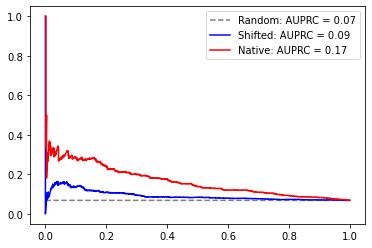

In [143]:
auprc_unshifted = sklearn.metrics.average_precision_score(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_unshifted'])
auprc_shifted = sklearn.metrics.average_precision_score(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_shifted'])
prec_unshifted, recall_unshifted, threshold_shifted = sklearn.metrics.precision_recall_curve(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_unshifted'])
prec_shifted, recall_shifted, threshold_shifted = sklearn.metrics.precision_recall_curve(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_shifted'])
random = np.sum(pred_obs_all['validated'])/len(pred_obs_all['validated'])
random_recall = np.array(list(range(0,len(prec_unshifted),1)))/len(prec_unshifted)
prec_random = np.array([random]*len(prec_unshifted))

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(random_recall,prec_random, color="grey", linestyle="dashed", label="Random: AUPRC = {:2.2f}".format(random))
ax.plot(recall_shifted,prec_shifted, color="blue", label="Shifted: AUPRC = {:2.2f}".format(auprc_shifted))
ax.plot(recall_unshifted,prec_unshifted, color="red", label="Native: AUPRC = {:2.2f}".format(auprc_unshifted))
# add diagonal
#ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=1)

In [64]:
np.sum(pred_obs_all['validated'])/len(pred_obs_all['validated'])

0.06861989205859677

In [51]:
print(sklearn.metrics.roc_auc_score(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_unshifted']))
print(sklearn.metrics.roc_auc_score(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_shifted']))

0.6964960242164182
0.5661194926044432


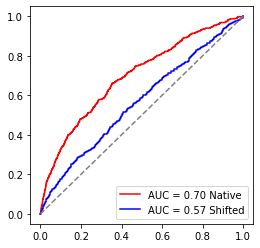

In [63]:
roc_auc_unshifted = sklearn.metrics.roc_auc_score(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_unshifted'])
roc_auc_shifted = sklearn.metrics.roc_auc_score(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_shifted'])
fpr_unshifted, tpr_unshifted, threshold_shifted = sklearn.metrics.roc_curve(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_unshifted'])
fpr_shifted, tpr_shifted, threshold_shifted = sklearn.metrics.roc_curve(pred_obs_all['validated'],pred_obs_all['Predicted_Percent_shifted'])

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(fpr_unshifted,tpr_unshifted, color="red", label="AUC = {:2.2f} Native".format(roc_auc_unshifted))
ax.plot(fpr_shifted,tpr_shifted, color="blue", label="AUC = {:2.2f} Shifted".format(roc_auc_shifted))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)